# Introduction

I love Asana, I'm a PM and they are a product company.
I like data science. I wanna explore Asana and it's competitors. I also want to play with and learn about the BERT model. This will be a curiosity-driven journey, not sure where it'll end.


# Packages

In [ ]:
# Package to store the versions of packages used
!pip install -q watermark

In [ ]:
# Package to download the BERT models and process data
!pip install -q transformers

In [ ]:
# Package for scrapping data on Google Store
# https://pypi.org/project/google-play-scraper/
!pip install -q google_play_scraper

In [ ]:
# File manipulation imports for Google Colab
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/BERT_App_Sentiment_Analysis")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Imports

# Data manipulation and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
from matplotlib import rc
from tqdm.notebook import tqdm
import datetime
from time import time


# Deep Learning, NLP and metrics
import sklearn
import torch
import transformers 
from textwrap import wrap
from torch import nn, optim 
from torch.utils import data
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from transformers import BertModel
from transformers import BertTokenizer
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

# Web Scrapping Imports
# https://pypi.org/project/Pygments/
import json
import pygments
import google_play_scraper
from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

# Random Seed
#RANDOM_SEED = 99
#np.random.seed(RANDOM_SEED)
#torch.manual_seed(RANDOM_SEED)

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Package versions
%reload_ext watermark
%watermark -v -iv

google_play_scraper 0.1
pandas              1.0.5
transformers        3.0.2
torch               1.6.0+cu101
json                2.0.9
seaborn             0.10.1
sklearn             0.22.2.post1
numpy               1.18.5
matplotlib          3.2.2
pygments            2.1.3
CPython 3.6.9
IPython 5.5.0


# Web Scrapping

In [ ]:
# Listing apps I want to gather data on
# They'll all be Asana's competitors on task management
# Took the apps from Asana's comparison page, plus a few other alternatives the app store recommends
# https://asana.com/compare
# Asana, Airtable, Basecamp, Jira, Microsoft To Do
# Monday.com, Smartsheet, Taskade, Trello, Wrike
# The google_play_scrapper documentations details how to get the url for each app
# https://github.com/facundoolano/google-play-scraper
apps_list = ['com.asana.app',
             'com.formagrid.airtable',
             'com.basecamp.bc3',
             'com.atlassian.android.jira.core',
             'com.microsoft.todos',
             'com.monday.monday',
             'com.smartsheet.android',
             'com.taskade.mobile',
             'com.trello',
             'com.wrike']

In [ ]:
# List to store details from the apps
app_details = []

# Loop through the app list and retrieve details of each app
for ap in tqdm(apps_list):

    # Retrieve app details
    info = google_play_scraper.app(ap, lang='en', country='us')

    # Store the details
    app_details.append(info)

100%|██████████| 10/10 [00:01<00:00,  6.24it/s]


In [ ]:
# Function to print a request in JSON format
def print_json(json_object):

    # Generate json format
    json_str = json.dumps(json_object,
                          indent = 2,
                          sort_keys = True,
                          default = str)
    
    # The highlight function from pygments highlights the output text 
    # It uses different colorts to facilitate reading
    print(highlight(json_str, JsonLexer(), TerminalFormatter()))

In [ ]:
# Check the result in JSON format
print_json(app_details[0])

{
  "adSupported": null,
  "androidVersion": "7.0",
  "androidVersionText": "7.0 and up",
  "appId": "com.asana.app",
  "comments": [
    "Absolute trash. Stay away from this app and just use the web version if you manage too many tasks and uses a lot of tags and different filters. Filter doesn't work correctly. Probably, the app obverloads because there are over a thousand tasks in our project already. And one more thing, when you browse the app for more than a minute and try to reload/refresh the window it doesn't load anymore. I guess this only works for smaller project with few number of tasks. The heck.",
    "Excellent app that allows a consolidated view of everything you have going. Some anomalies could be improved. Task duration would be good to see. Additionally associating subtasks with their project works also make things easier. Overall a great app though. Easy to use and a great mobile app too. Really worth using too improve project management and collaboration.",
    "I l

In [ ]:
# Put the retrieved information into a dataframe
df_app_details = pd.DataFrame(app_details)

In [ ]:
# Save the dataframe to disk

# Retrieve datetime to stamp the file
now = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

# Save with current datetime
df_app_details.to_csv(f'data/app_details_{now}.csv', header=True, index=None)

In [ ]:
df_app_details.head(3)

,title,description,descriptionHTML,summary,summaryHTML,installs,minInstalls,score,ratings,reviews,histogram,price,free,currency,sale,saleTime,originalPrice,saleText,offersIAP,inAppProductPrice,size,androidVersion,androidVersionText,developer,developerId,developerEmail,developerWebsite,developerAddress,privacyPolicy,developerInternalID,genre,genreId,icon,headerImage,screenshots,video,videoImage,contentRating,contentRatingDescription,adSupported,containsAds,released,updated,version,recentChanges,recentChangesHTML,comments,appId,url
0,Asana: Your work manager,Asana is the work manager for teams. But bette...,Asana is the work manager for teams. But bette...,Organize. Plan. Get work done. #withAsana,Organize. Plan. Get work done. #withAsana,"1,000,000+",1000000,4.583608,31564,9667,"[1433, 529, 1267, 3283, 25052]",0,True,USD,False,None,None,None,False,None,14M,7.0,7.0 and up,"Asana, Inc.","Asana,+Inc.",support@asana.com,https://asana.com/product,None,http://www.asana.com/privacy,9027419648812383370,Business,BUSINESS,https://lh3.googleusercontent.com/EJEviNAy8fAd...,https://lh3.googleusercontent.com/4ts1ELx9Kpks...,[https://lh3.googleusercontent.com/a-c_cZ7cTlT...,https://www.youtube.com/embed/jY0-gsNImlk?ps=p...,https://i.ytimg.com/vi/jY0-gsNImlk/hqdefault.jpg,Everyone,None,None,None,"Feb 27, 2013",1597360715,6.51.5,🎵 Give a little bit...\r\nGive a little bit of...,🎵 Give a little bit...<br>Give a little bit of...,[Absolute trash. Stay away from this app and j...,com.asana.app,https://play.google.com/store/apps/details?id=...
1,Airtable,Organize anything you can imagine with Airtabl...,Organize anything you can imagine with Airtabl...,Organize anything you can imagine with a moder...,Organize anything you can imagine with a moder...,"100,000+",100000,3.671053,1546,774,"[295, 101, 112, 346, 692]",0,True,USD,False,None,None,None,False,None,13M,5.0,5.0 and up,Airtable,8024614373053231272,droid@airtable.com,https://airtable.com/,None,https://airtable.com/privacy,8024614373053231272,Productivity,PRODUCTIVITY,https://lh3.googleusercontent.com/0AKPNIi6-Dct...,https://lh3.googleusercontent.com/xlIqHp_kgI76...,[https://lh3.googleusercontent.com/u1iubbqRbdB...,https://www.youtube.com/embed/rydOfdGCOBU?ps=p...,https://i.ytimg.com/vi/rydOfdGCOBU/hqdefault.jpg,Everyone,None,None,None,"Sep 27, 2016",1596736428,1.4.2,Organize anything you can imagine with Airtabl...,Organize anything you can imagine with Airtabl...,[Won't let me sign in with Google account unle...,com.formagrid.airtable,https://play.google.com/store/apps/details?id=...
2,Basecamp 3,<b>Use your company's Basecamp 3 account on-th...,<b>Use your company&#39;s Basecamp 3 account o...,"Basecamp 3, official Android version for the w...","Basecamp 3, official Android version for the w...","500,000+",500000,4.274314,4179,1524,"[260, 156, 375, 771, 2617]",0,True,USD,False,None,None,None,False,None,7.6M,6.0,6.0 and up,Basecamp,Basecamp,support@basecamp.com,https://basecamp.com,None,https://basecamp.com/privacy,8645525805030592144,Productivity,PRODUCTIVITY,https://lh3.googleusercontent.com/Mx66p8uDSlbx...,https://lh3.googleusercontent.com/DhvIpWbDmOr1...,[https://lh3.googleusercontent.com/o_oaonXHNi5...,None,None,Everyone,None,None,None,"Oct 20, 2015",1582299579,3.18.9,🐛 Bug fixes and improved speed over slow networks,🐛 Bug fixes and improved speed over slow networks,[Very bad UX. 1) No progress (% wise) shown fo...,com.basecamp.bc3,https://play.google.com/store/apps/details?id=...


In [ ]:
# List to store app reviews
app_reviews = []

# Loop to retrieve and store app reviews
for ap in tqdm(apps_list):

    # Extract sample reviews from reviews with different stars given
    for star in list(range(1, 6)):

        # Extract the most relevant and the most recent reviews
        for sort_order in [google_play_scraper.Sort.MOST_RELEVANT, google_play_scraper.Sort.NEWEST]:
            rvws, _ = google_play_scraper.reviews(ap,
                                                  lang='en',
                                                  country='us',
                                                  sort=sort_order,
                                                  count = 100 if star == 3 else 50,
                                                  filter_score_with = star)
            
            for r in rvws:
                r['sortOrder'] = 'most_relevant' if sort_order == google_play_scraper.Sort.MOST_RELEVANT else 'newest'
                r['appId'] = ap

            # Save reviews
            app_reviews.extend(rvws)

100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


In [ ]:
# Create a dataframe with the reviews
df_app_reviews = pd.DataFrame(app_reviews)

In [ ]:
# Save the dataframe to disk

# Retrieve datetime to stamp the file
now = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

# Save with current datetime
df_app_reviews.to_csv(f'data/app_reviews_{now}.csv', header = True, index = None)

In [ ]:
# Loading the csv with app reviews
df_reviews = pd.read_csv(f'data/app_reviews_{now}.csv')
df_reviews.head(3)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOHTV7PdCc2qccT5aehUpoV3mB0PaGYuGP6VoAr...,Anne Amit,https://lh3.googleusercontent.com/a-/AOh14GiyP...,Absolute trash. Stay away from this app and ju...,1,7,6.50.8,2020-08-11 02:40:35,NaN,NaN,most_relevant,com.asana.app
1,gp:AOqpTOGjmtD5IJRa-8Rk7hxS02RFs1oyJgdDwFOXbsj...,mrk 1,https://lh3.googleusercontent.com/-HCdJh-McJWE...,At first looked very promising (specially UI) ...,1,34,6.46.6,2020-06-11 23:50:05,NaN,NaN,most_relevant,com.asana.app
2,gp:AOqpTOHVo18xZthD7fpEma0cvNOrtqWv49Kw9yzdi2O...,Kunal Sareen,https://lh3.googleusercontent.com/a-/AOh14GhWG...,Just downloaded it. I'm unable to sign up. Is ...,1,0,6.51.4,2020-08-06 06:30:13,Hi Kunal I'm sorry to hear you are having trou...,2020-08-13 17:13:13,most_relevant,com.asana.app


In [ ]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5434 entries, 0 to 5433
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              5434 non-null   object
 1   userName              5434 non-null   object
 2   userImage             5434 non-null   object
 3   content               5434 non-null   object
 4   score                 5434 non-null   int64 
 5   thumbsUpCount         5434 non-null   int64 
 6   reviewCreatedVersion  4885 non-null   object
 7   at                    5434 non-null   object
 8   replyContent          1837 non-null   object
 9   repliedAt             1837 non-null   object
 10  sortOrder             5434 non-null   object
 11  appId                 5434 non-null   object
dtypes: int64(2), object(10)
memory usage: 509.6+ KB


Text(0, 0.5, 'Total')

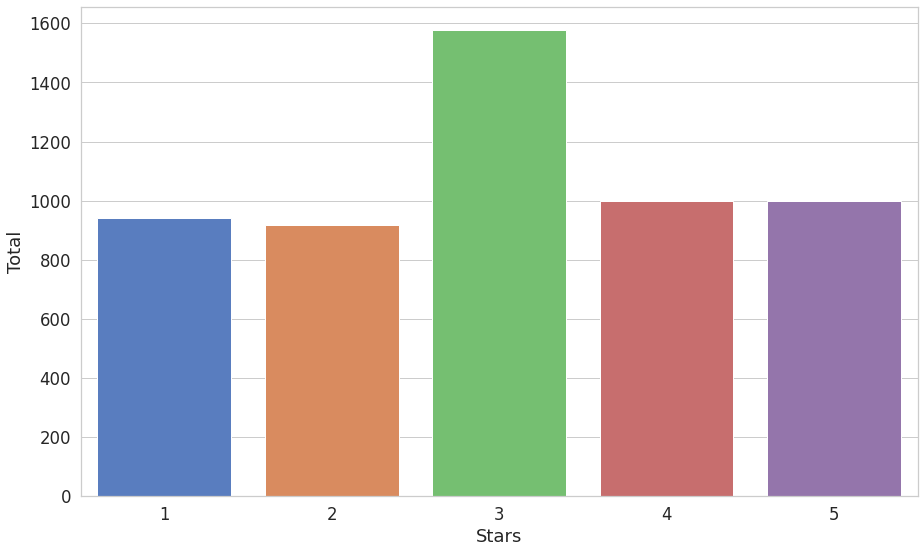

In [ ]:
# Plot stars
sns.set(style = 'whitegrid', palette = 'muted', font_scale = 1.5)
rcParams['figure.figsize'] = 15, 9
sns.countplot(df_reviews.score)
plt.xlabel('Stars')
plt.ylabel('Total')

Text(0, 0.5, 'Number of Samples')

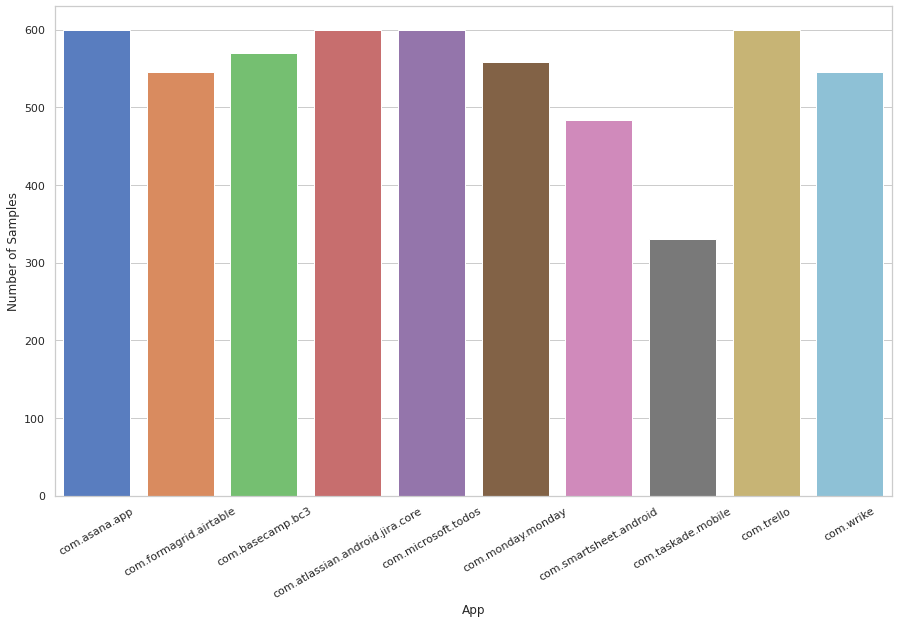

In [ ]:
# Plot appId
sns.set(style = 'whitegrid', palette = 'muted', font_scale = 1)
rcParams['figure.figsize'] = 15, 9
ax = sns.countplot(df_reviews.appId)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.xlabel('App')
plt.ylabel('Number of Samples')

In [ ]:
# Creating a pivot table to see which app x star combination didn't retrieve the desired amount of data
app_x_stars = df_reviews.groupby(['appId', 'score']).size().unstack()
app_x_stars

score,1,2,3,4,5
appId,,,,,
com.asana.app,100,100,200,100,100
com.atlassian.android.jira.core,100,100,200,100,100
com.basecamp.bc3,100,100,170,100,100
com.formagrid.airtable,100,100,146,100,100
com.microsoft.todos,100,100,200,100,100
com.monday.monday,100,100,158,100,100
com.smartsheet.android,100,100,84,100,100
com.taskade.mobile,42,16,72,100,100
com.trello,100,100,200,100,100


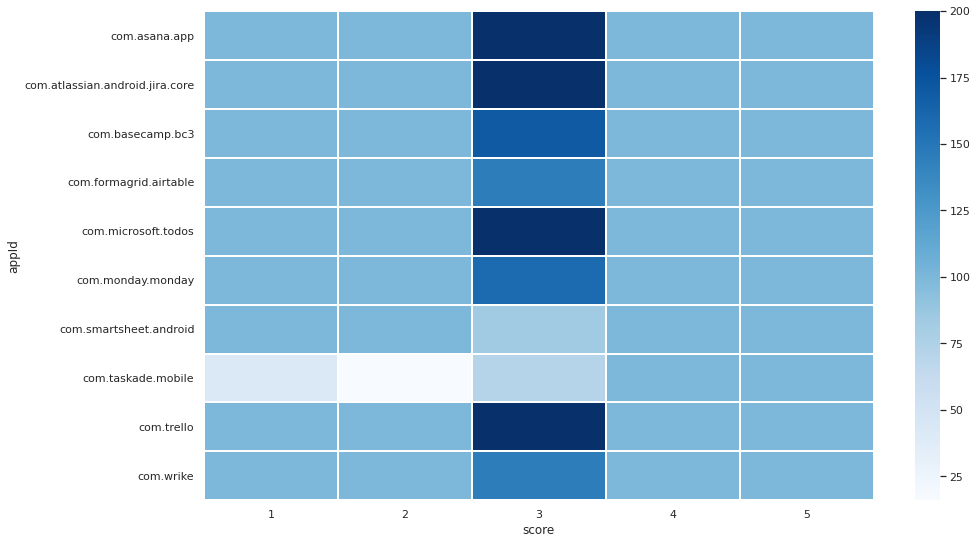

In [ ]:
# Plotting app x stars as a heatmap
sns.heatmap(app_x_stars, linewidths=1, linecolor='white', cmap='Blues')

# Preprocessing

In [ ]:
# Grouping function
# This will convert range of 1-5 star reviews into negative(0), neutral(1) and positive(2)
# This is why I've gathered twice as much data for 3 star reviews
def group_rating(rating):

    # initialize groups on -1 to catch any bugs
    grp_rating = -1 

    # Convert ratings to integers
    rating = int(rating)

    # If the rating is above 3, then positive (2)
    if rating > 3:
        grp_rating = 2
    
    # If rating is 3, then neutral (1)
    elif rating == 3:
        grp_rating = 1
    
    # If rating is below 3, then negative (0)
    else:
        grp_rating = 0
    
    return grp_rating

In [ ]:
# Apply the function to the dataset and create a 'sentiment' column with the output
df_reviews['sentiment'] = df_reviews.score.apply(group_rating)

In [ ]:
df_reviews.head(3)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment
0,gp:AOqpTOHTV7PdCc2qccT5aehUpoV3mB0PaGYuGP6VoAr...,Anne Amit,https://lh3.googleusercontent.com/a-/AOh14GiyP...,Absolute trash. Stay away from this app and ju...,1,7,6.50.8,2020-08-11 02:40:35,NaN,NaN,most_relevant,com.asana.app,0
1,gp:AOqpTOGjmtD5IJRa-8Rk7hxS02RFs1oyJgdDwFOXbsj...,mrk 1,https://lh3.googleusercontent.com/-HCdJh-McJWE...,At first looked very promising (specially UI) ...,1,34,6.46.6,2020-06-11 23:50:05,NaN,NaN,most_relevant,com.asana.app,0
2,gp:AOqpTOHVo18xZthD7fpEma0cvNOrtqWv49Kw9yzdi2O...,Kunal Sareen,https://lh3.googleusercontent.com/a-/AOh14GhWG...,Just downloaded it. I'm unable to sign up. Is ...,1,0,6.51.4,2020-08-06 06:30:13,Hi Kunal I'm sorry to hear you are having trou...,2020-08-13 17:13:13,most_relevant,com.asana.app,0


In [ ]:
# Shuffling the dataframe to avoid biasing the model later on
df_reviews = df_reviews.sample(frac=1).reset_index(drop=True)

In [ ]:
# List with class names
class_names = ['negative', 'neutral', 'positive']

In [ ]:
print(f'Negative: {(len(df_reviews[df_reviews.sentiment == 0])/len(df_reviews))}')
print(f'Neutral: {(len(df_reviews[df_reviews.sentiment == 1])/len(df_reviews))}')
print(f'Positive: {(len(df_reviews[df_reviews.sentiment == 2])/len(df_reviews))}')

Negative: 0.3419212366580788
Neutral: 0.29002576370997424
Positive: 0.368052999631947


Text(0, 0.5, 'Total')

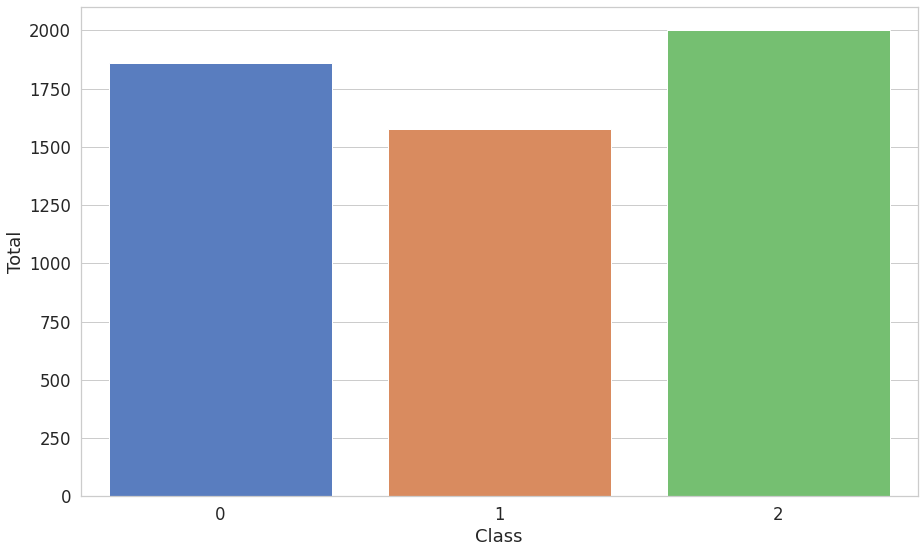

In [ ]:
# Plot class distribution
sns.set(style = 'whitegrid', palette = 'muted', font_scale = 1.5)
rcParams['figure.figsize'] = 15, 9
sns.countplot(df_reviews.sentiment)
plt.xlabel('Class')
plt.ylabel('Total')

Downloading the pre-treined BERT model.

List of available models: https://github.com/google-research/bert

In [ ]:
# Model download
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
# Test text
test_text = 'Just a test sentence. Test 2.'
test_text

'Just a test sentence. Test 2.'

In [ ]:
# Tokenize
tokens = tokenizer.tokenize(test_text)
tokens

['Just', 'a', 'test', 'sentence', '.', 'Test', '2', '.']

In [ ]:
# Extract the token_ids
token_ids = tokenizer.convert_tokens_to_ids(tokens)
token_ids

[2066, 170, 2774, 5650, 119, 5960, 123, 119]

In [ ]:
# Create the encoding object to format the data for the BERT model
encoding = tokenizer.encode_plus(test_text,
                                 max_length = 32,
                                 add_special_tokens = True,
                                 pad_to_max_length = True,
                                 return_attention_mask = True,
                                 return_token_type_ids = False,
                                 return_tensors = 'pt')

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
# Print
encoding

{'input_ids': tensor([[ 101, 2066,  170, 2774, 5650,  119, 5960,  123,  119,  102,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])}

Applying the BERT tokenizer to the dataset

In [ ]:
# List for the tokens
token_length = []

In [ ]:
# Drop NaN values before tokenizing
df_reviews = df_reviews.dropna(subset=['content'], how='all')
df_reviews.reset_index(inplace = True, drop=True)
df_reviews.shape

(5434, 13)

In [ ]:
# Loop through the dataset content applying the tokenizer
for content in df_reviews.content:
    tokens = tokenizer.encode(content)
    token_length.append(len(tokens))

In [ ]:
# Sample of contents
df_reviews.content.tail(5)

5429    I bought the Garmin intinct. Shouldnt have to ...
5430                                            Great app
5431    After latest update, I am not getting alert wh...
5432    Decent enough app but when it says you can soo...
5433    Overall it is a good app. But it doesn't have ...
Name: content, dtype: object

Text(0.5, 0, 'Token Length')

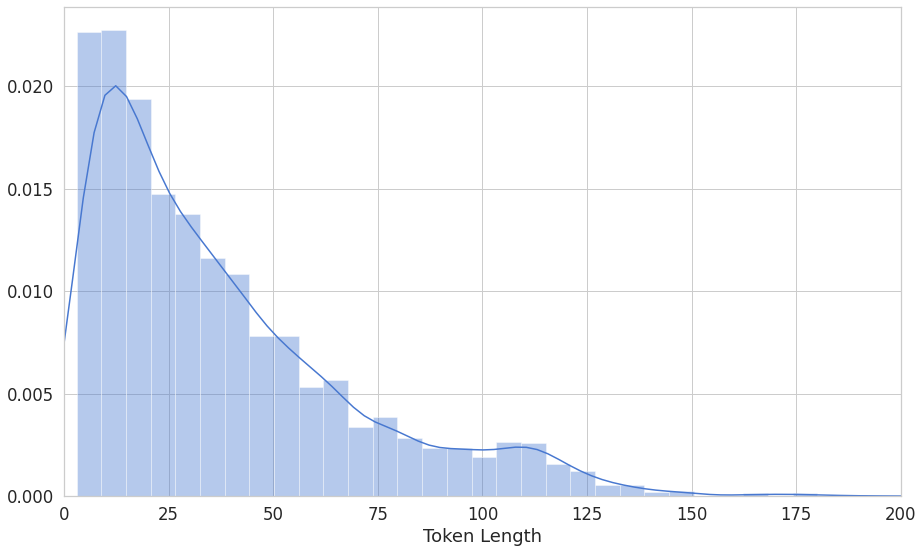

In [ ]:
# Plot
ax = sns.distplot(token_length)
plt.xlim([0, 200])
plt.xlabel('Token Length')

# Configurations

In [ ]:
# Model Hyperparameters
EPOCHS = 10
BATCH_SIZE = 16
MAX_LENGTH = 150
LEARNING_RATE = 0.00002 
'''
Spent about 7 hours debugging this model to find out that the learning rate
has to be precisely 2e^-5 as anything else was causing the model not to learn at all
'''

'\nSpent about 7 hours debugging this model to find out that the learning rate\nhas to be precisely 2e^-5 as anything else was causing the model not to learn at all\n'

# Data Batching

In [ ]:
class DataBatcher(data.Dataset):

    # Constructor
    def __init__(self, review, targets, tokenizer, max_len):

        # Initialize class atributes
        self.review = review
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.review)

    # Method to obtain each review
    def __getitem__(self, item):

        # Load a review
        review = str(self.review[item])

        # Create the review embedding
        encoding = tokenizer.encode_plus(review,
                                         max_length = self.max_len,
                                         truncation=True,
                                         add_special_tokens = True,
                                         pad_to_max_length = True,
                                         return_attention_mask = True,
                                         return_token_type_ids = False,
                                         return_tensors = 'pt')
        
        # Among the methods returns, there is the attention mask
        return {'review_text': review,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'targets': torch.tensor(self.targets[item], dtype = torch.long)}

In [ ]:
# This function creates a data loader to convert the dataset to the BERT format
# torch.utils.data.dataloader.DataLoader
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = DataBatcher(review = df.content.to_numpy(),
                     targets = df.sentiment.to_numpy(),
                     tokenizer = tokenizer,
                     max_len = max_len)
    
    return data.DataLoader(ds, batch_size = batch_size, num_workers = 4)

In [ ]:
# Train test split
df_train, df_test = train_test_split(df_reviews, test_size = 0.2) #, random_state = RANDOM_SEED

In [ ]:
# Test validation split
df_valid, df_test = train_test_split(df_test, test_size = 0.5) #, random_state = RANDOM_SEED

In [ ]:
print(f'df_train.shape: {df_train.shape}')
print(f'df_test.shape: {df_test.shape}')
print(f'df_valid.shape: {df_valid.shape}')

df_train.shape: (4347, 13)
df_test.shape: (544, 13)
df_valid.shape: (543, 13)


In [ ]:
# Load the data_loaders
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LENGTH, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LENGTH, BATCH_SIZE)
valid_data_loader = create_data_loader(df_valid, tokenizer, MAX_LENGTH, BATCH_SIZE)

In [ ]:
# Visualize a sample on the training data
sample = next(iter(train_data_loader))
print(sample['input_ids'].shape)
print(sample['attention_mask'].shape)
print(sample['targets'].shape)

torch.Size([16, 150])
torch.Size([16, 150])
torch.Size([16])


In [ ]:
# Single review sample already on BERT format
print(sample)

{'review_text': ['one of the best apps for managing team tasks and projects.', "Good app overall but $25 as the lowest price? Create another plan for \nsingle user for like 10-15 and I'll rate 5 stars. I'm pretty sure I'm not \nthe only one who would like this.", 'An updated review after using it for sometime. My day experience does not do the trick (compared to TickTick or Anydo), also the widget (only one) is frequently being blanck unresponsive (app is allowed to autostart and work in background). The missing of some collaborative features (shared reminders and notes in tasks) is felt. The design is very nice and it has potential but it seems some what behind other trending ToDo and task/time management apps.', 'There is less than zero reason why I should be forced to use an app when a browser works just as well. Aggressively anti-user. Would give zero stars if allowed.', 'Not provide enough functionality and UI is also not great', 'Super slow!', "I like being able to group tasks in

# Model

In [ ]:
# Loading the pre-trained BERT model
model_bert = BertModel.from_pretrained('bert-base-cased')

In [ ]:
# Model
model_bert

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [ ]:
# Visualize the shape of the last dense layer and the last pooling layer
last_hidden_state, pooled_output = model_bert(input_ids = encoding['input_ids'], attention_mask = encoding['attention_mask'])

In [ ]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [ ]:
pooled_output.shape

torch.Size([1, 768])

Adding the layers relative to my specific model.

Only those get trained in practice.

In [ ]:
class SentimentClassifier(nn.Module):

    # Constructor
    def __init__ (self, n_classes):

        # Initialize atributes
        super(SentimentClassifier, self).__init__()

        # Define the pre-trained BERT model
        self.bert = BertModel.from_pretrained('bert-base-cased')

        # Add a dropout layer
        self.drop1 = nn.Dropout()

        # Add a hidden layer
        self.fc1 = nn.Linear(self.bert.config.hidden_size, 100)

        # Add a dense layer
        self.fc2 = nn.Linear(100, n_classes)

        # Final classification with softmax
        self.softmax = nn.Softmax(dim = 1)

    # Forward method
    def forward(self, input_ids, attention_mask):

        # Load the pooling layer from BERT
        _, pooled_output = self.bert(input_ids = input_ids, attention_mask = attention_mask)

        # Define the outputs from the created layers
        output = self.drop1(pooled_output)
        output = self.fc1(output)
        output = self.fc2(output)

        # Return
        return self.softmax(output)

In [ ]:
# Setting the device to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
# Create instance of the model
model_sentiment_classifier = SentimentClassifier(len(class_names))

In [ ]:
# Send model to the device
model_sentiment_classifier = model_sentiment_classifier.to(device)

In [ ]:
# Load the inputs and attention mask
input_ids = sample['input_ids'].to(device)
attention_mask = sample['attention_mask'].to(device)

In [ ]:
# Print
print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 150])
torch.Size([16, 150])


In [ ]:
# Load the inputs and attention mask onto the model
model_sentiment_classifier(input_ids, attention_mask)

tensor([[0.1884, 0.2524, 0.5592],
        [0.2807, 0.3305, 0.3889],
        [0.2970, 0.2641, 0.4389],
        [0.3275, 0.2102, 0.4623],
        [0.3776, 0.3209, 0.3015],
        [0.2210, 0.3212, 0.4578],
        [0.3367, 0.2361, 0.4272],
        [0.3171, 0.1802, 0.5027],
        [0.2176, 0.2531, 0.5293],
        [0.2990, 0.3012, 0.3998],
        [0.1812, 0.2638, 0.5550],
        [0.2374, 0.3093, 0.4533],
        [0.2253, 0.2722, 0.5025],
        [0.2991, 0.3004, 0.4005],
        [0.2198, 0.2879, 0.4922],
        [0.2438, 0.2448, 0.5113]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [ ]:
# The original BERT model uses AdamW: algorithm with fixed decay weight
optimizer = AdamW(model_sentiment_classifier.parameters(), lr = LEARNING_RATE, correct_bias = False)

In [ ]:
# Defining the total number of steps
total_step = len(train_data_loader) * EPOCHS

In [ ]:
# Adjust the learning rate
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_step)

In [ ]:
# Loss function
loss_fn = nn.CrossEntropyLoss().to(device)
#loss_fn = nn.NLLLoss().to(device)
#loss_fn = nn.MultiMarginLoss().to(device)

In [ ]:
# Train function
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):

    # Prepare for training
    model = model.train()
    losses = []
    correct_prediction = 0

    # Loop through the data samples
    # Complete Deep Learing cicle
    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)
        outputs = model(input_ids = input_ids, attention_mask = attention_mask)

        _, preds = torch.max(outputs, dim = 1)
        loss = loss_fn(outputs, targets)

        correct_prediction += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_prediction.double() / n_examples, np.mean(losses)

In [ ]:
# Evaluate function
def evaluate_model(model, data_loader, loss_fn, device, n_examples):

    model.eval()
    losses = []
    correct_prediction = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)
            outputs = model(input_ids = input_ids, attention_mask = attention_mask)

            _, preds = torch.max(outputs, dim = 1)
            loss = loss_fn(outputs, targets)

            correct_prediction += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_prediction.double() / n_examples, np.mean(losses)

# Training

In [ ]:
%%time

# Store the train history
history = defaultdict(list)

# Control the best accuracy
now = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
best_accuracy = 0

# Loop
for epoch in range(EPOCHS):

    start_time = time()

    print(f'Epoch {epoch+1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_model(model_sentiment_classifier,
                                        train_data_loader,
                                        loss_fn,
                                        optimizer,
                                        device,
                                        scheduler,
                                        len(df_train))
    
    print(f'Train error: {train_loss} Train accuracy: {train_acc}')

    valid_acc, valid_loss = evaluate_model(model_sentiment_classifier,
                                           valid_data_loader,
                                           loss_fn,
                                           device,
                                           len(df_valid))
    
    print(f'Validation error: {valid_loss} Validation accuracy: {valid_acc}')
    print()

    end_time = time()

    print(f'Iteration Time: {end_time - start_time:.2f} seconds')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)

    history['valid_acc'].append(valid_acc)
    history['valid_loss'].append(valid_loss)

    if valid_acc > best_accuracy:
        torch.save(model_sentiment_classifier.state_dict(), f'models/model_sentiment_classifier_{now}.bin')
        best_accuracy = valid_acc

Epoch 1/10
----------
Train error: 0.9397852414232843 Train accuracy: 0.5914423740510697
Validation error: 0.9063669460661271 Validation accuracy: 0.6445672191528545

Iteration Time: 125.50 seconds

Epoch 2/10
----------
Train error: 0.8145275078713894 Train accuracy: 0.732919254658385
Validation error: 0.8095266152830685 Validation accuracy: 0.7403314917127072

Iteration Time: 125.97 seconds

Epoch 3/10
----------
Train error: 0.7411843742079595 Train accuracy: 0.8088336783988958
Validation error: 0.7691685101565193 Validation accuracy: 0.7790055248618785

Iteration Time: 125.73 seconds

Epoch 4/10
----------
Train error: 0.7094255646362024 Train accuracy: 0.8398895790200138
Validation error: 0.7510087893289679 Validation accuracy: 0.8011049723756907

Iteration Time: 125.48 seconds

Epoch 5/10
----------
Train error: 0.6831568909042022 Train accuracy: 0.8679549114331723
Validation error: 0.7873804236159605 Validation accuracy: 0.7605893186003684

Iteration Time: 125.30 seconds

Epoch 

Model trained and saved to disk!

In [ ]:
history

defaultdict(list,
            {'train_acc': [tensor(0.5914, device='cuda:0', dtype=torch.float64),
              tensor(0.7329, device='cuda:0', dtype=torch.float64),
              tensor(0.8088, device='cuda:0', dtype=torch.float64),
              tensor(0.8399, device='cuda:0', dtype=torch.float64),
              tensor(0.8680, device='cuda:0', dtype=torch.float64),
              tensor(0.8762, device='cuda:0', dtype=torch.float64),
              tensor(0.8889, device='cuda:0', dtype=torch.float64),
              tensor(0.8949, device='cuda:0', dtype=torch.float64),
              tensor(0.8963, device='cuda:0', dtype=torch.float64),
              tensor(0.8976, device='cuda:0', dtype=torch.float64)],
             'train_loss': [0.9397852414232843,
              0.8145275078713894,
              0.7411843742079595,
              0.7094255646362024,
              0.6831568909042022,
              0.6748957454281694,
              0.662339240531711,
              0.6572280528352541,
   

# Evaluate Model

In [ ]:
# Create a model instance
model = SentimentClassifier(len(class_names))

In [ ]:
# Load the model
model.load_state_dict(torch.load(f'models/model_sentiment_classifier_{now}.bin'))

<All keys matched successfully>

In [ ]:
# Send model to device
model = model.to(device)

In [ ]:
# Predicting using test data
test_acc, test_loss = evaluate_model(model, test_data_loader, loss_fn, device, len(df_test))

In [ ]:
# Model performance
print(f'Test Accuracy:  {test_acc}')
print(f'Test Loss:      {test_loss}')

Test Accuracy:  0.7867647058823529
Test Loss:      0.7642380612737992


In [ ]:
# Function to collect reviews
def get_reviews(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d['review_text']
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)
            outputs = model(input_ids = input_ids, attention_mask = attention_mask)

            _, preds = torch.max(outputs, dim = 1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [ ]:
# Gathering real data
y_review_texts, y_pred, y_pred_probs, y_test = get_reviews(model, test_data_loader)

In [ ]:
# Classification report
print(classification_report(y_test, y_pred, target_names = class_names))

              precision    recall  f1-score   support

    negative       0.84      0.84      0.84       187
     neutral       0.67      0.77      0.72       162
    positive       0.84      0.75      0.79       195

    accuracy                           0.79       544
   macro avg       0.79      0.79      0.79       544
weighted avg       0.79      0.79      0.79       544



In [ ]:
y_pred_probs

tensor([[9.9983e-01, 9.3685e-05, 7.3604e-05],
        [5.8328e-05, 6.1615e-05, 9.9988e-01],
        [4.4207e-05, 4.7958e-04, 9.9948e-01],
        ...,
        [4.6431e-05, 7.9586e-05, 9.9987e-01],
        [9.9936e-01, 5.1191e-04, 1.3140e-04],
        [7.8072e-05, 5.3968e-05, 9.9987e-01]])

In [ ]:
# Function to plot confusion matrix
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot = True, fmt = "d", cmap = "Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation = 0, ha = "right")
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation = 30, ha = "right")
    plt.ylabel('Real Sentiment')
    plt.xlabel('BERT Predicted Sentiment')

In [ ]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

In [ ]:
df_cm = pd.DataFrame(cm, index = class_names, columns = class_names)

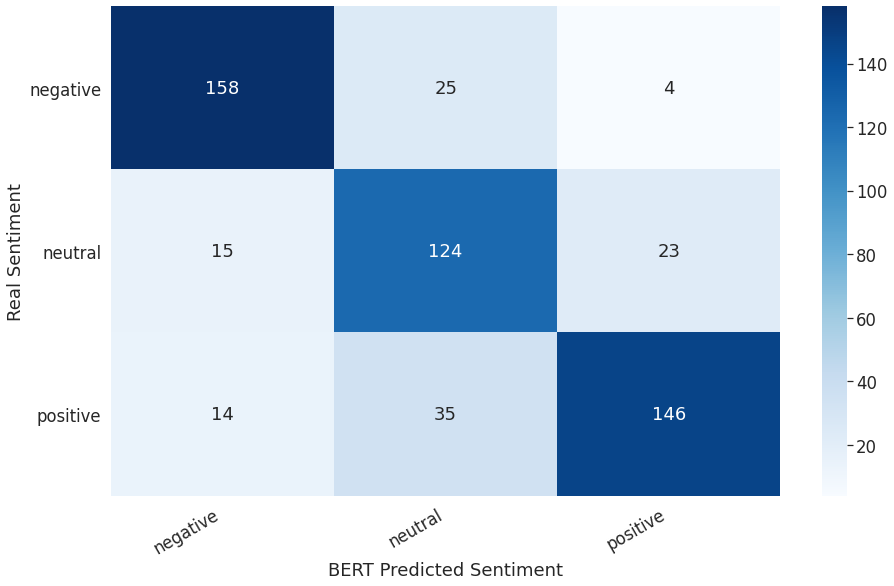

In [ ]:
# Result
show_confusion_matrix(df_cm)

In [ ]:
# Checking one review
idx = 0

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]

pred_df = pd.DataFrame(
    {
        'class_names': class_names,
        'values': y_pred_probs[idx]
    }
)

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'Real Sentiment: {class_names[true_sentiment]}')

Forces to accept business trial, impossible to downgrade. Contacting
customer support is convoluted, and impossible. I followed
instructions in Business Class email for support, which ended up with
issue closed before issue was addressed.

Real Sentiment: negative


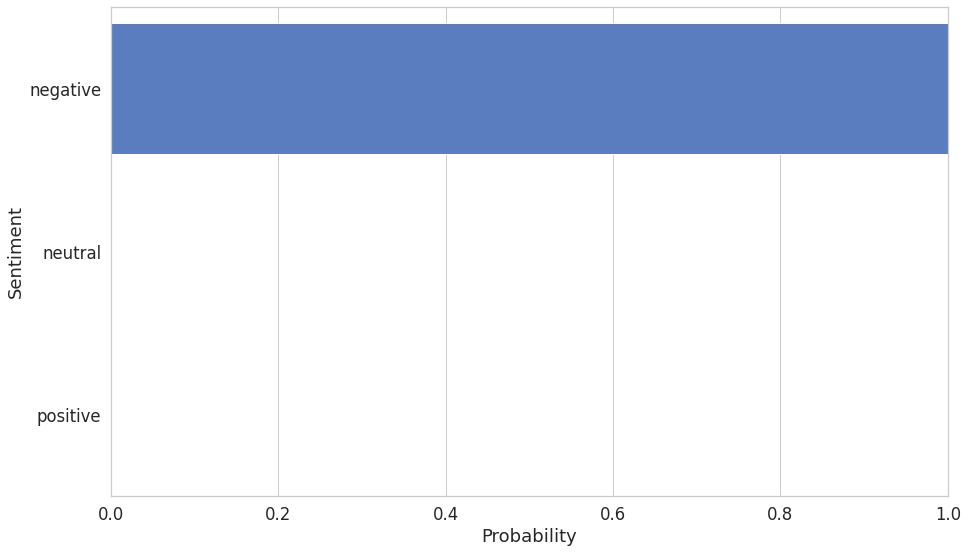

In [ ]:
# Prediction plot
sns.barplot(x = 'values', y = 'class_names', data = pred_df, orient = 'h')
plt.ylabel('Sentiment')
plt.xlabel('Probability')
plt.xlim([0, 1]);

Testing with new data (s new app review).

In [ ]:
test_text = 'I really love this app. It improved my work organization and efficiency'

In [ ]:
# Apply the same transformation which was applied to the training data, creating the embedding object
encoded_eval = tokenizer.encode_plus(test_text,
                                     max_length = MAX_LENGTH,
                                     add_special_tokens= True,
                                     return_token_type_ids = False,
                                     pad_to_max_length = True,
                                     return_attention_mask = True,
                                     return_tensors = 'pt')

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
# Extract the inputs and attention_mask to make a prediction
input_ids = encoded_eval['input_ids'].to(device)
attention_mask = encoded_eval['attention_mask'].to(device)

In [ ]:
# Output (prediction)
output = model(input_ids, attention_mask)

In [ ]:
# Final prediction
probability, prediction = torch.max(output, dim = 1)

In [ ]:
# Print
print(f'\nApp Review Text: {test_text}')
print(f'\nSentiment: {class_names[prediction]}')
print(f'\nProbability: {probability[0]}')


App Review Text: I really love this app. It improved my work organization and efficiency

Sentiment: positive

Probability: 0.999880313873291


# The End